In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [2]:
# Define paths and parameters
dataset_path = '/kaggle/input/natural-images/natural_images/'
target_size = (256,256)

# Function to apply Sobel filter
def apply_sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.magnitude(sobel_x, sobel_y)

count =0
# Function to load and process images
def load_and_process_images(dataset_path, target_size):
    global count
    original_images = []
    sobel_images = []
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for image_name in os.listdir(category_path):
            count+=1
            if count<=4000:
                image_path = os.path.join(category_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    resized_image = cv2.resize(image, target_size)
                    original_images.append(resized_image)
                    sobel_images.append(apply_sobel_filter(resized_image))
            else:
                return np.array(original_images), np.array(sobel_images)
                
    return np.array(original_images), np.array(sobel_images)


# Load images
original_images, sobel_images = load_and_process_images(dataset_path, target_size)
# Expand dimensions and normalize
original_images_resized = np.expand_dims(original_images, axis=-1) / 255.0
sobel_images_resized = np.expand_dims(sobel_images, axis=-1) / 255.0

In [3]:
print(original_images_resized.shape,sobel_images_resized.shape)

(4000, 256, 256, 1) (4000, 256, 256, 1)


In [4]:
import numpy as np

# Function to perform rotation by 90, 180, and 270 degrees
def rotate_images(images, sobel_images):
    augmented_images = []
    augmented_sobel_images = []
    
    for image, sobel_image in zip(images, sobel_images):
        # Add original images
        augmented_images.append(image)
        augmented_sobel_images.append(sobel_image)
        
#         # Rotate 90 degrees
#         rotated_image_90 = np.rot90(image, k=1)
#         rotated_sobel_90 = np.rot90(sobel_image, k=1)
#         augmented_images.append(rotated_image_90)
#         augmented_sobel_images.append(rotated_sobel_90)
        
#         # Rotate 180 degrees
#         rotated_image_180 = np.rot90(image, k=2)
#         rotated_sobel_180 = np.rot90(sobel_image, k=2)
#         augmented_images.append(rotated_image_180)
#         augmented_sobel_images.append(rotated_sobel_180)
        
# #         Rotate 270 degrees
#         rotated_image_270 = np.rot90(image, k=3)
#         rotated_sobel_270 = np.rot90(sobel_image, k=3)
#         augmented_images.append(rotated_image_270)
#         augmented_sobel_images.append(rotated_sobel_270)
    
    return np.array(augmented_images), np.array(augmented_sobel_images)

# Apply the rotation-based augmentation
X_augmented, y_augmented = rotate_images(original_images_resized, sobel_images_resized)

# Verify the shapes
print("Augmented Images Shape:", X_augmented.shape)
print("Augmented Sobel Images Shape:", y_augmented.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the split
print("Training Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Test Set Shape:", X_test.shape)


Augmented Images Shape: (4000, 256, 256, 1)
Augmented Sobel Images Shape: (4000, 256, 256, 1)
Training Set Shape: (2800, 256, 256, 1)
Validation Set Shape: (600, 256, 256, 1)
Test Set Shape: (600, 256, 256, 1)


In [5]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define an improved Sobel model
def create_improved_sobel_model(input_shape):
    inputs = Input(shape=input_shape)

    # Downsample
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)

    # Upsample
    up1 = UpSampling2D((2, 2))(conv3)
    up1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)

    conv2_upsampled = UpSampling2D((2, 2))(conv2)  # Upsample conv2 to match the shape of up1
    up1 = Add()([up1, conv2_upsampled])  # Residual connection

    up2 = UpSampling2D((2, 2))(up1)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)

    conv1_upsampled = UpSampling2D((2, 2))(conv1)  # Upsample conv1 to match the shape of up2
    up2 = Add()([up2, conv1_upsampled])  # Residual connection
    
    # Output layer
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model





input_shape = (256,256,1)
model = create_improved_sobel_model(input_shape)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    295,040 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ max_pooling2d_1[… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │ up_sampling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │     73,792 │ up_sampling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_4[0][0]  

 Total params: 741,633 (2.83 MB)

 Trainable params: 740,353 (2.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/15


I0000 00:00:1725184063.103563     106 service.cc:145] XLA service 0x7a554c0485e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725184063.103647     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725184063.103653     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725184087.412220     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 ━━━━━━━━━━━━━━━━━━━━ 77s 281ms/step - loss: 0.0683 - mae: 0.1654 - val_loss: 0.1286 - val_mae: 0.1982 - learning_rate: 0.0010
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - loss: 0.0275 - mae: 0.0835 - val_loss: 0.0892 - val_mae: 0.1667 - learning_rate: 0.0010
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 260ms/step - loss: 0.0245 - mae: 0.0731 - val_loss: 0.0463 - val_mae: 0.1164 - learning_rate: 0.0010
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - loss: 0.0238 - mae: 0.0698 - val_loss: 0.0272 - val_mae: 0.0778 - learning_rate: 0.0010
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 259ms/step - loss: 0.0227 - mae: 0.0654 - val_loss: 0.0237 - val_mae: 0.0652 - learning_rate: 0.0010
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - loss: 0.0217 - mae: 0.0613 - val_loss: 0.0231 - val_mae: 0.0622 - learning_rate: 9.0484e-04
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - loss: 0.0210 - mae: 0.0595 - val_loss: 0.0226 - val_mae: 0.0603 - learning_rate:

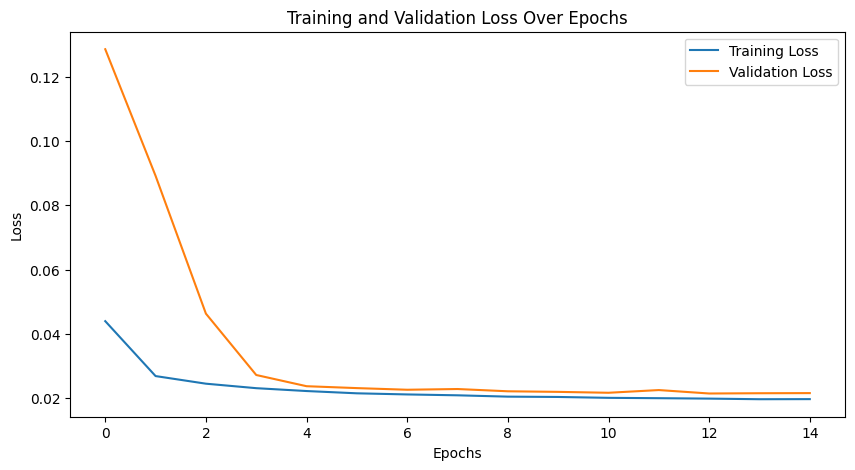

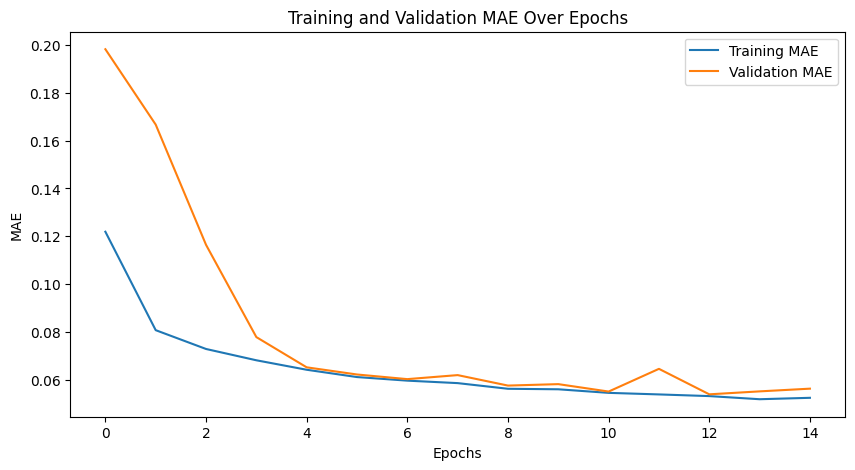

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Define learning rate scheduler and early stopping
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1).numpy()

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=[lr_callback, early_stopping]
)

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting MAE (Mean Absolute Error) over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [7]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate SSIM for a sample image
index = 0
ssim_value = ssim(y_test[index].squeeze(), y_pred[index].squeeze(), data_range=1.0)
print(f"SSIM Value: {ssim_value}")



19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 818ms/step - loss: 0.0203 - mae: 0.0515
Test Loss: 0.020072931423783302
Test MAE: 0.05163709446787834
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step
SSIM Value: 0.8535657585472471


In [14]:
# Calculate accuracy by comparing binary masks
def calculate_accuracy(y_true, y_pred, threshold=0.01):
    y_true_binary = (y_true > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = np.mean(y_true_binary == y_pred_binary)
    return accuracy

# Calculate accuracy for the test set
test_accuracy = calculate_accuracy(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 93.50%


In [9]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_sobel_model_no_pooling(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers without pooling
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)

    # Additional convolutional layers to increase feature extraction depth
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)

    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)

    # Output layer
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Example usage
input_shape = (256, 256, 1)
model = create_sobel_model_no_pooling(input_shape)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256, 256, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,633 (2.83 MB)

 Trainable params: 740,353 (2.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [10]:
import cv2
import numpy as np

# Function to apply Laplacian filter
def apply_laplacian_filter(image):
    return cv2.Laplacian(image, cv2.CV_64F, ksize=3)

# Function to apply Prewitt filter
def apply_prewitt_filter(image):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=int)
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=int)
    prewitt_x = cv2.filter2D(image, -1, kernelx)
    prewitt_y = cv2.filter2D(image, -1, kernely)
    return cv2.magnitude(prewitt_x, prewitt_y)

# Modify load_and_process_images function to include these filters
def load_and_process_images_with_filters(dataset_path, target_size):
    original_images = []
    sobel_images = []
    laplacian_images = []
    prewitt_images = []

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                original_images.append(resized_image)
                sobel_images.append(apply_sobel_filter(resized_image))
                laplacian_images.append(apply_laplacian_filter(resized_image))
                prewitt_images.append(apply_prewitt_filter(resized_image))

    return (np.array(original_images), np.array(sobel_images),
            np.array(laplacian_images), np.array(prewitt_images))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


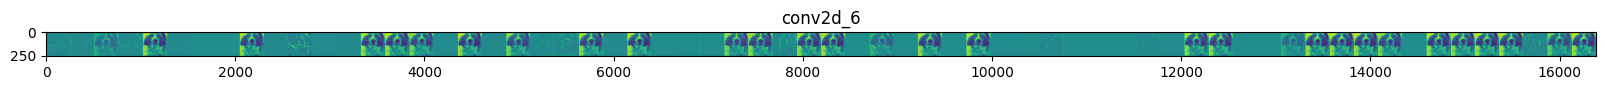

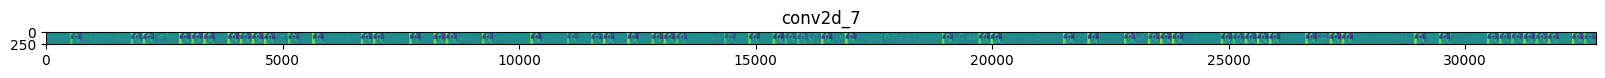

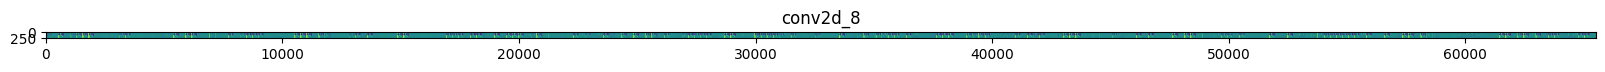

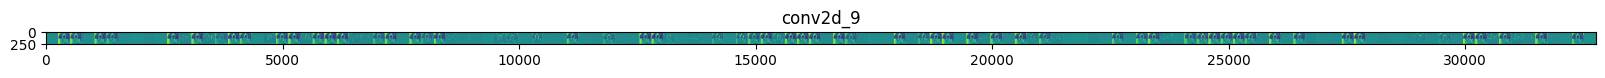

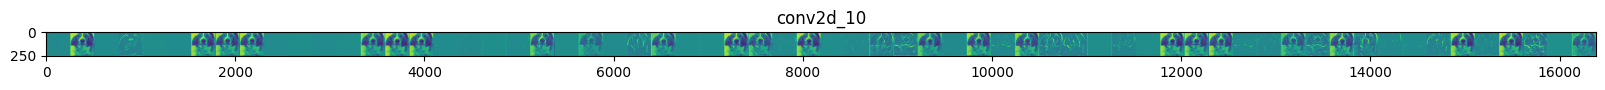

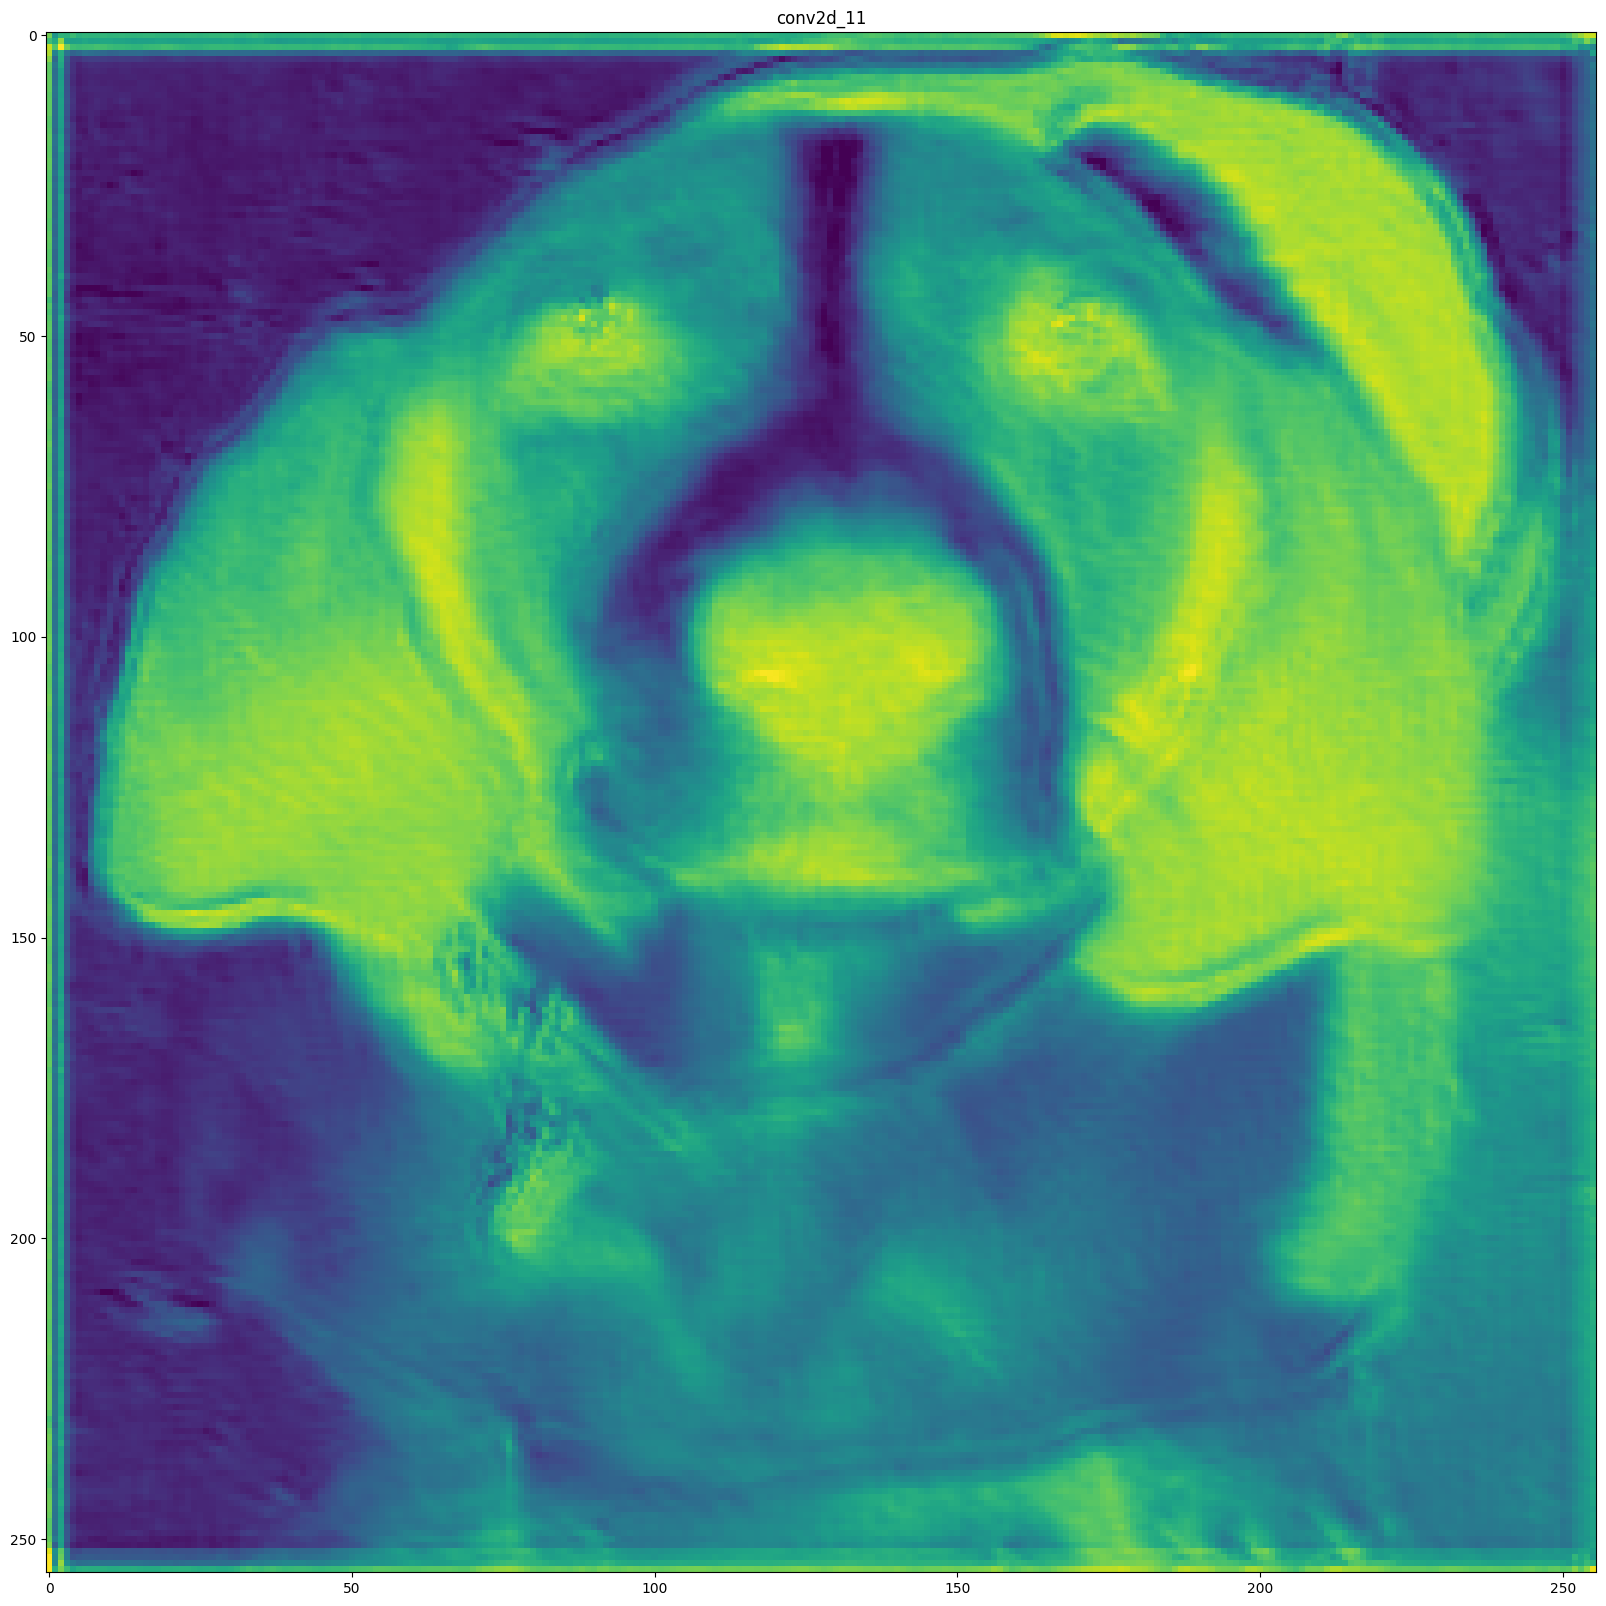

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models

def visualize_feature_maps(model, image):
    # Ensure the model is built
    if not model.built:
        model.build((None,) + model.input_shape[1:])
    
    # Create a model to output the feature maps of each convolutional layer
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, layers.Conv2D)]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    # Get the feature maps for the given image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    activations = activation_model.predict(image)

    # Plot each feature map
    for layer_name, activation in zip([layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)], activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= x.std() + 1e-5
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Example usage for visualization
visualize_feature_maps(model, X_test[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


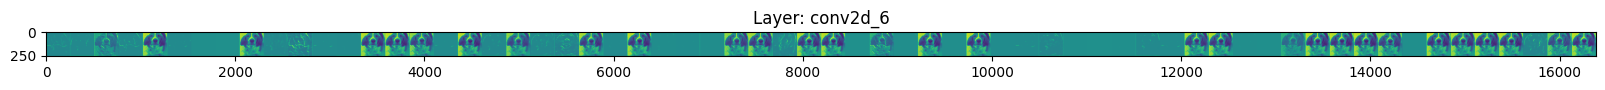

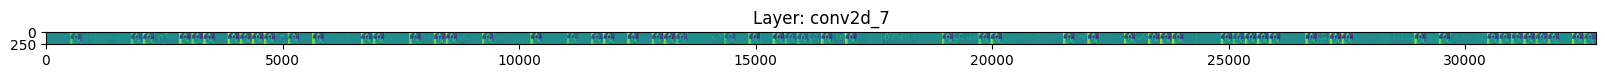

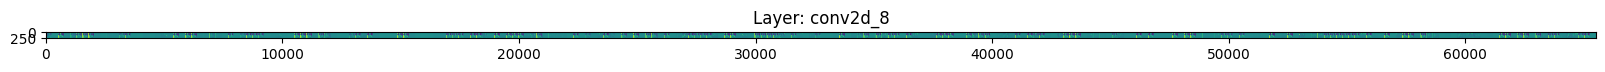

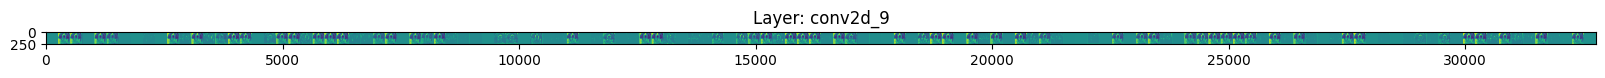

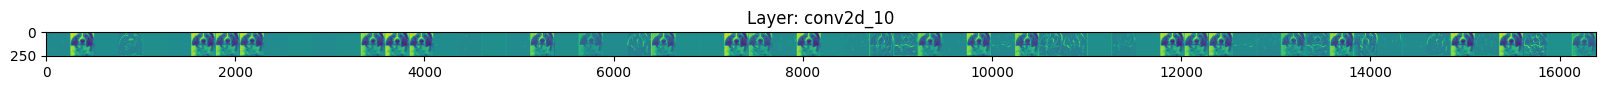

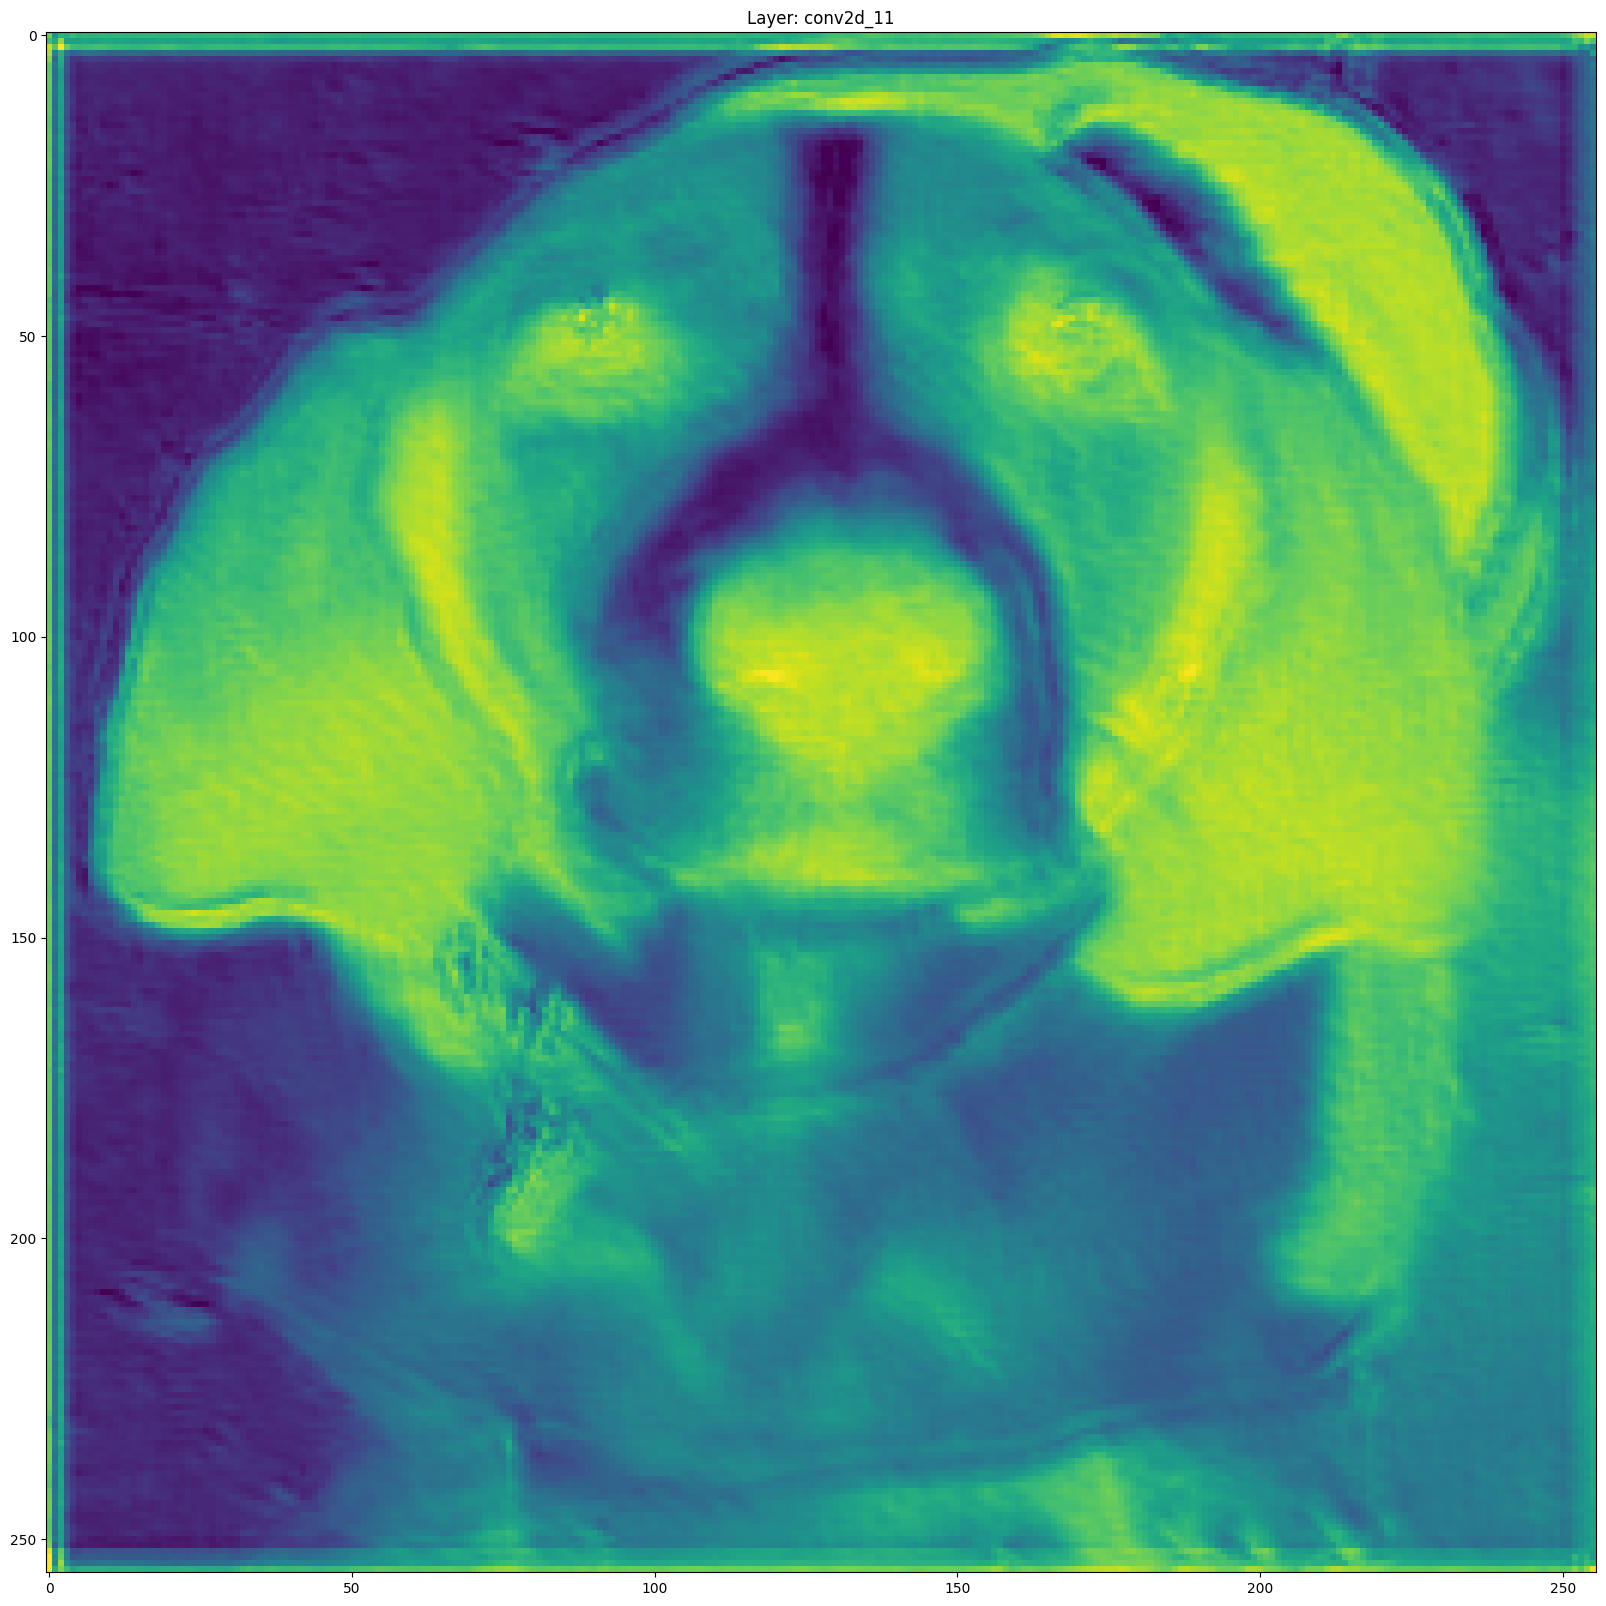

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_feature_maps(model, image):
    # Ensure the model is built
    if not model.built:
        model.build((None,) + model.input_shape[1:])

    # Define a function to get feature maps from convolutional layers
    def get_feature_maps(layer_outputs, image):
        # Create a model to extract features
        feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
        return feature_map_model.predict(image[np.newaxis, ...])

    # Collect outputs from convolutional layers
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    
    # Get feature maps for the given image
    activations = get_feature_maps(layer_outputs, image)
    
    # Plot feature maps
    for layer_name, activation in zip([layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)], activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= x.std() + 1e-5
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'Layer: {layer_name}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Example usage for visualization
visualize_feature_maps(model, X_test[0])


In [13]:
def create_alternative_filter_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Example usage
input_shape = (128, 128, 1)
model_alternative = create_alternative_filter_model(input_shape)

# Train and evaluate the alternative model similarly to the previous models
history_alternative = train_filter_model(model_alternative, X_train_sobel, y_train_sobel, X_val_sobel, y_val_sobel)
evaluate_filter_model(model_alternative, X_test_sobel, y_test_sobel)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'train_filter_model' is not defined